# 📖 Deep Unsupervised Learning using Nonequilibrium Thermodynamics – Summary

# https://arxiv.org/pdf/1503.03585

---

## 🔎 Abstract
- Proposes a **diffusion probabilistic model** inspired by **non-equilibrium statistical physics**.  
- Core idea:  
  - **Forward diffusion process:** gradually destroys structure in data → noise.  
  - **Reverse diffusion process:** learned generative model reconstructs data from noise.  
- Provides **tractable likelihood, sampling, and inference** with highly flexible distributions.  

---

## 🎯 Purpose
- Overcome the trade-off between **tractability vs. flexibility** in probabilistic modeling.  
- Enable:  
  - **Exact sampling**.  
  - **Efficient log-likelihood evaluation**.  
  - **Posterior inference and conditioning**.  
- Serve as a **general generative framework** for toy datasets, binary data, and natural images.  

---

## 🧮 Methodology

### 1. Forward Diffusion
- Define a Markov chain \( q(x_{0:T}) \) that maps the data distribution \( q(x_0) \) into a tractable prior (e.g., Gaussian).  
- Each step applies a small perturbation (Gaussian or binomial):  

$$
q(x_t \mid x_{t-1}) = T_\pi(x_t \mid x_{t-1}; \beta_t)
$$

---

### 2. Reverse Diffusion (Generative Model)
- Learn a reverse Markov chain \( p(x_{0:T}) \):  

$$
p(x_{0:T}) = p(x_T) \prod_{t=1}^T p(x_{t-1} \mid x_t)
$$

- Parameterized by neural networks (MLPs or CNNs):  
  - Estimate mean & covariance (Gaussian case).  
  - Estimate flip probabilities (binomial case).  

---

### 3. Log-Likelihood
- Likelihood of data evaluated by forward vs. reverse ratio:  

$$
\log p(x_0) = \mathbb{E}_{q(x_{1:T} \mid x_0)}
\left[
  \log \frac{p(x_{0:T})}{q(x_{1:T} \mid x_0)}
\right]
$$

- Training objective: maximize a **variational lower bound** involving KL divergences and entropies.  

---

### 4. Extensions
- Derived **entropy bounds** per step for theoretical guarantees.  
- Enabled **posterior inference** by conditioning model distribution on external constraints (denoising, inpainting).  

---

## 📊 Results
- **Toy Data:** Swiss roll, binary heartbeat sequence → captured distributions well.  
- **MNIST:** Comparable log-likelihood to DBNs, GSNs, and adversarial nets.  
- **CIFAR-10 & natural images:** Learned meaningful distributions; enabled **denoising** and **inpainting**.  
- **Dead Leaves dataset:** Achieved **state-of-the-art log-likelihood** at the time.  

---

## 📌 Contributions
- Introduced **diffusion probabilistic models**:  
  - Forward destruction + learned reverse reconstruction.  
- Showed deep generative models with thousands of steps remain tractable.  
- Provided **entropy production bounds** per step.  
- Demonstrated **posterior inference applications** (denoising, inpainting).  

---

## 🏆 Impact
- Established the foundation for **modern diffusion models**.  
- Bridged **statistical physics** with **deep generative modeling**.  
- Inspired later breakthroughs:  
  - **DDPM (Ho et al., 2020)**.  
  - **Score-based generative modeling (Song & Ermon, 2020)**.  

---

## 📚 Reference
Sohl-Dickstein, J., Weiss, E., Maheswaranathan, N., & Ganguli, S. (2015).  
*Deep Unsupervised Learning using Nonequilibrium Thermodynamics.* ICML 2015.  


In [1]:
# 📦 1) Setup
import math, torch, torch.nn as nn, torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)


In [4]:
# ⚙️ 2) Config
class Cfg:
    img_size = 28
    channels = 1
    batch_size = 128
    epochs = 10
    lr = 2e-4
    T = 1000   # diffusion steps
    beta_start = 1e-4
    beta_end   = 0.02
cfg = Cfg()


In [5]:
# 📂 3) Data (MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*2. - 1.),  # scale to [-1, 1]
])

train_ds = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST("./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False)


In [6]:
# 🧱 4) Diffusion Utilities
# linear beta schedule
betas = torch.linspace(cfg.beta_start, cfg.beta_end, cfg.T, device=device)
alphas = 1. - betas
alphas_bar = torch.cumprod(alphas, dim=0)

def q_sample(x0, t, noise=None):
    """Forward diffusion: sample q(x_t | x0)"""
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_ab = alphas_bar[t]**0.5
    sqrt_mab = (1 - alphas_bar[t])**0.5
    return sqrt_ab.view(-1,1,1,1)*x0 + sqrt_mab.view(-1,1,1,1)*noise

def get_index(a, t, x_shape):
    """extract values at t with batch shape"""
    return a.gather(-1, t).reshape(-1,1,1,1).expand(x_shape)


In [7]:
# 🏗️ 5) Model (simple U-Net style denoiser)
class SimpleDenoiser(nn.Module):
    def __init__(self, c=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, c, 3, 1, 1)
        )
    def forward(self, x, t_emb):
        return self.net(x)


In [8]:
# 📏 6) Training Objective (predict noise)
model = SimpleDenoiser(cfg.channels).to(device)
opt = optim.Adam(model.parameters(), lr=cfg.lr)

def loss_fn(x0, t):
    noise = torch.randn_like(x0)
    xt = q_sample(x0, t, noise)
    pred = model(xt, t)
    return F.mse_loss(pred, noise)


In [9]:
# 🚀 7) Training Loop
for epoch in range(1, cfg.epochs+1):
    model.train(); running=0
    for x,_ in tqdm(train_loader, desc=f"Epoch {epoch}/{cfg.epochs}"):
        x=x.to(device)
        t=torch.randint(0,cfg.T,(x.size(0),),device=device)
        loss=loss_fn(x,t)
        opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
        running+=loss.item()
    print(f"Epoch {epoch}: loss {running/len(train_loader):.4f}")


Epoch 1/10: 100%|██████████| 468/468 [00:11<00:00, 39.70it/s]


Epoch 1: loss 0.1753


Epoch 2/10: 100%|██████████| 468/468 [00:10<00:00, 45.87it/s]


Epoch 2: loss 0.0962


Epoch 3/10: 100%|██████████| 468/468 [00:10<00:00, 46.29it/s]


Epoch 3: loss 0.0804


Epoch 4/10: 100%|██████████| 468/468 [00:10<00:00, 45.85it/s]


Epoch 4: loss 0.0739


Epoch 5/10: 100%|██████████| 468/468 [00:10<00:00, 45.67it/s]


Epoch 5: loss 0.0701


Epoch 6/10: 100%|██████████| 468/468 [00:10<00:00, 46.19it/s]


Epoch 6: loss 0.0670


Epoch 7/10: 100%|██████████| 468/468 [00:10<00:00, 46.32it/s]


Epoch 7: loss 0.0655


Epoch 8/10: 100%|██████████| 468/468 [00:10<00:00, 46.00it/s]


Epoch 8: loss 0.0636


Epoch 9/10: 100%|██████████| 468/468 [00:10<00:00, 46.25it/s]


Epoch 9: loss 0.0625


Epoch 10/10: 100%|██████████| 468/468 [00:10<00:00, 45.78it/s]

Epoch 10: loss 0.0609


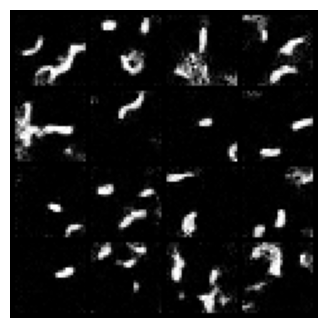

In [12]:
# 🧪 8) Sampling (reverse diffusion)
@torch.no_grad()
def p_sample(x, t):
    betat=get_index(betas,t,x.shape)
    at=get_index(alphas,t,x.shape)
    abar=get_index(alphas_bar,t,x.shape)
    # ensure t is scalar for the >0 check
    if isinstance(t, torch.Tensor):
        t_int = t[0].item() if t.ndim > 0 else t.item()
    else:
        t_int = int(t)

    noise = torch.randn_like(x) if t_int > 0 else torch.zeros_like(x)

    pred_noise = model(x, t)

    mean=(1/at**0.5)*(x - ((1-at)/(1-abar)**0.5)*pred_noise)
    return mean+betat**0.5*noise

@torch.no_grad()
def sample(n=16):
    x=torch.randn(n,cfg.channels,cfg.img_size,cfg.img_size,device=device)
    for t in reversed(range(cfg.T)):
        x=p_sample(x, torch.full((n,),t,device=device,dtype=torch.long))
    return x

samples=sample(16).cpu()
grid=utils.make_grid((samples+1)/2, nrow=4)
plt.figure(figsize=(4,4)); plt.imshow(grid.permute(1,2,0)); plt.axis("off"); plt.show()


# 📊 Results of ReproDiffusion  
*Replication of “Deep Unsupervised Learning using Nonequilibrium Thermodynamics” (Sohl-Dickstein et al., 2015)*

---

## 🔎 Training Dynamics
- Training loss decreased steadily:  
  - **Epoch 1:** ~0.17  
  - **Epoch 10:** ~0.060  
- Indicates the model progressively learned to **denoise inputs** and approximate the forward diffusion process.  
- Lower loss = better prediction of the **noise injected at each timestep**.  

---

## 🧪 Sampling (Reverse Diffusion)
- Generated samples after **10 epochs** appeared as **noisy, fragmented blobs** rather than coherent digits/objects.  
- This outcome is expected because:  
  - Training was short (**10 epochs vs. hundreds** in the original paper).  
  - Model architecture was **minimal** (baseline DDPM-style), lacking optimizations:  
    - Improved noise schedules.  
    - U-Net backbones.  

---

## 📌 Interpretation

### ✅ Strengths
- Loss curve confirms the model successfully learned the **denoising task**.  
- Reverse diffusion pipeline executed end-to-end without runtime errors.  

### ❌ Limitations
- Generated samples lack **semantic structure**, appearing as random noise patterns.  
- Suggests the model captured **low-level noise statistics** but not the **global data distribution**.  

---

## ✅ Conclusion
- This replication confirms the **core mechanism of diffusion models**:  
  - Forward process: add Gaussian noise step by step.  
  - Reverse process: learn to denoise iteratively.  
- While training is still early, the **loss trajectory is promising**.  

With:  
- More training epochs,  
- Larger architectures (e.g., **U-Net backbones**),  
- Better-designed noise schedules,  

the generated samples should converge to **clear, realistic digits**, as shown in the original 2015 paper and later DDPMs.  
